# Ligand Selection and Preparation, Docking and Analysis

This notebook contains the code necessary to; prepare the ligands for docking, run docking in smina, and analyse the results of the docking.

In [1]:
# Ensure docking-env is activated as kernel.

# Import all libraries that are required.

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdmolfiles import MolToPDBFile
import os
import pandas as pd
import numpy as np
from standardiser import standardise

DATAPATH = '../data'
RESULTSPATH = '../results'


## Ligand Selection, Validation and Standardisation

Ligand selection step involves;

- Identification of ligands (from generative model, DB's, etc) and extraction as smiles strings
- Standardisation - smiles-->mol, mol--> smiles, removal of any ligands that have no smiles
- Filtering of ligands (based on pharmacophore matching score, eos models, synthetic likelihood, etc)

Note on using Erilia 'find similar compounds' models - these return a .csv file with input smiles, then all similar smiles in one cell, comma separated. These can be separated by 'text to columns', and this gives the smiles in a row. Can then select all manually (shift), cut, paste and transpose. Then find " ' " and replace with nothing. Must add in an 'ID' column, can just have numbers (1-x), as this must be called to be used as filename when converting smiles->mols for 3D gen. Save.

In [ ]:
# Ligand standardisation code here - smiles -> mol -> standard mol -> standard smiles

csv_file = os.path.join(DATAPATH, "chembl", "smallmols.csv")

df=pd.read_csv(csv_file) 

mols = [Chem.MolFromSmiles(smi) for smi in df["SMILES"].tolist()]

std_mols = []

for mol in mols:
    if mol is not None:
        try:
            std_mol = standardise.run(mol)
        except:
            std_mol = np.nan
    else:
        std_mol = np.nan
    std_mols += [std_mol]

std_smiles = []

for std_mol in std_mols:
    if std_mol is not None:
        try: 
            std_smi = Chem.MolToSmiles(std_mol)
        except:
            std_smi=np.nan
    else:
        std_smi = np.nan
    std_smiles += [std_smi]

df["ST_SMILES"] = std_smiles

df=df[df["ST_SMILES"].notna()]

df.drop(columns = ["SMILES"], inplace=True)

df.to_csv('../data/chembl/std_smallmols.csv', index=False)

## Ligand Preparation

- Conversion of smiles strings to 3D conformers using RDKIT 
- Protonation at a specific pH (7.4) and conversion to .pdbqt via obabel
- OR
- Protonation at a specific pH, conversion to .sdf and merging of all .sdf files into one .sdf file containing all ligands

In [3]:
std_csv_file = os.path.join(DATAPATH, "chembl", "std_smallmols.csv")
pH = 7.4
sdf_folder = os.path.join(DATAPATH, "chembl")

In [4]:
# The below takes a .csv file with smiles strings and converts them to a single .sdf file containing all smiles strings in protonated 3D format.

def prepare_ligands_sdf(std_csv_file, pH, header_len=1, output_dir = sdf_folder, delim=',') -> list:
  
    out_sdfs = [] # Creates an empty list to fill.
    
    print(std_csv_file)
    
    with open(std_csv_file, 'r') as csv: 
        
        
        for entry in csv.readlines()[header_len:]:
            
            ID, ST_SMILES = entry.split(delim)[:2]            
           
            # Convert smiles str to 3D coordinates
            mol = Chem.MolFromSmiles(ST_SMILES)
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol)
            
    
            # Ouput coords to pdb
            pdb_name = f"{output_dir}/{ID}.pdb"
            MolToPDBFile(mol, pdb_name)
            
            # Protonate according to pH, convert to .sdf
            sdf_name = f"{output_dir}/{ID}.sdf"
            ! obabel {pdb_name} -pH {pH} -O {sdf_name}
            
            os.remove(pdb_name) # removes the .pdb files after obabel protonates and converts to .sdf
            
            out_sdfs.append(sdf_name)
            
    return out_sdfs


def merge_sdfs(out_sdfs, merged_sdf):

    mols = []
    for s in out_sdfs:
        suppl = Chem.SDMolSupplier(s)
        for  i, mol in enumerate(suppl):
            if mol is None:
                print(i)
                continue
            else:
                mols += [mol]
        os.remove(s)

    with Chem.SDWriter(merged_sdf) as w:
        for mol in mols:
            w.write(mol)

def prepare_and_merge_ligands(std_csv_file,  pH, header_len=1, output_dir='', delim=','):
    ligands = prepare_ligands_sdf(std_csv_file,  pH, header_len, output_dir, delim)
    merge_sdfs(ligands, output_dir+"/smallmols_merged.sdf")
        

In [ ]:
prepare_and_merge_ligands(std_csv_file, pH, output_dir=sdf_folder)

# Docking with smina

- Receptor is prepped manually for this project using ADTools (waters removed, polar hydrogens added, Gasteiger charges added, saved as .pdbqt file)
- Flexible side chains identified (not done below...)
- Ligand (CHO) can be readded as hetatm/different chain for autobox generation
- smina run (search space defined on command line) and outputs saved

In [6]:
# The below is smina, run using the single .sdf file with all ligands, nconf=1. 

receptor = '../data/protein/pabb_model1.pdbqt'  # Receptor
ligands = '../data/chembl/smallmols_merged.sdf'  # Ligand
log = '../results/chembl/smallmols_vinardo_log.txt' # log file
path_to_results = '../results/chembl/smallmols_vinardo_output.sdf' 
path_to_smina = '../src/smina.static'

cmd = path_to_smina  + " -r " + receptor + " -l " + ligands + " -o " + path_to_results + " --log " + log + " --seed 42 " + " --center_x 74 " + " --center_y 44 " + " --center_z 57 " + " --size_x 22 " + " --size_y 22 " + " --size_z 24 " + " --exhaustiveness 4 " + " --num_modes 1 " + " --addH off " + " --scoring vinardo "

os.system(cmd)

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.045       gauss(o=0,_w=0.8,_c=8)
0.8          repulsion(o=0,_c=8)
-0.035       hydrophobic(g=0,_b=2.5,_c=8)
-0.6         non_dir_h_bond(g=-0.6,_b=0,_c=8)
0            num_tors_div

Using random seed: 42

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.9       0.000      0.000    
Refi



An internal error occurred in ../../../src/lib/tree.h(133). 

Please report this error at http://smina.sf.net
Please remember to include the following in your problem report:
    * the EXACT error message,
    * your version of the program,
    * the type of computer system you are running it on,
	* all command line options,
	* configuration file (if used),
    * ligand file as PDBQT,
    * receptor file as PDBQT,
	* flexible side chains file as PDBQT (if used),
	* output file as PDBQT (if any),
    * input (if possible),
	* random seed the program used (this is printed when the program starts).

Thank you!


256

## Analysis

Here, the top poses will be selected and analysed.

- See SDSorter, with 'reduceconf' and 'nbestx'
- Also see 'sminalog_analysis.py'

In [10]:
#this takes the std_simles csv and links to affinities score, with descriptors

mypath = os.path.join(RESULTSPATH, "chembl")
logfile = os.path.join(mypath, 'smallmols_vinardo_log.txt')
affinities = os.path.join(mypath, 'affinities.csv')
affinities_header = os.path.join(mypath, 'affinities_header.csv')
std_csv_file = os.path.join(DATAPATH, "chembl", "std_smallmols.csv")
affinities_and_smiles = os.path.join(mypath, 'affinities_with_stdsmiles.csv')
csv_with_200_descriptors = os.path.join(mypath, 'csv_with_200desc.csv')
affinities_plus_desc = os.path.join(mypath, "affinities_smiles_descriptors.csv")                                                           

with open(logfile, "r") as f:
    i = 0;
    for line in f:
        if '-+' in line:
            nextline = next(f)
            i = i + 1

            nextlinearray  = nextline.split()                       #splitting the first row in different values
            bind_aff = nextlinearray[1]                             #getting the binding affinity of first pose

            with open(affinities, "a") as myfile:
                 print(bind_aff, end='\n', file=myfile)
    

df = pd.read_csv(affinities, names = ['AFFINITY'])

headerList = ['AFFINITY']
df.to_csv(affinities_header, header=headerList, index=False)
df = pd.read_csv(affinities_header)

os.remove(affinities)

df1 = pd.read_csv(std_csv_file)
df2 = pd.read_csv(affinities_header)

merged = pd.concat([df1, df2], axis="columns")
# merged.drop(columns = ["ID"], inplace=True) -- this removes the ID line, so output is smiles and affininty only... could keep.

merged.to_csv(affinities_and_smiles, index=False)

os.remove(affinities_header)

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

df = pd.read_csv(affinities_and_smiles)

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df['ST_SMILES'])

df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors.to_csv(csv_with_200_descriptors)

cols = [5, 115, 116]
df_with_important_descriptors = df_with_200_descriptors[df_with_200_descriptors.columns[cols]]

df1 = df
df2 = df_with_important_descriptors
merged = pd.concat([df1, df2], axis="columns")

merged.to_csv(affinities_plus_desc, index=False)

os.remove(affinities_and_smiles)
os.remove(csv_with_200_descriptors)


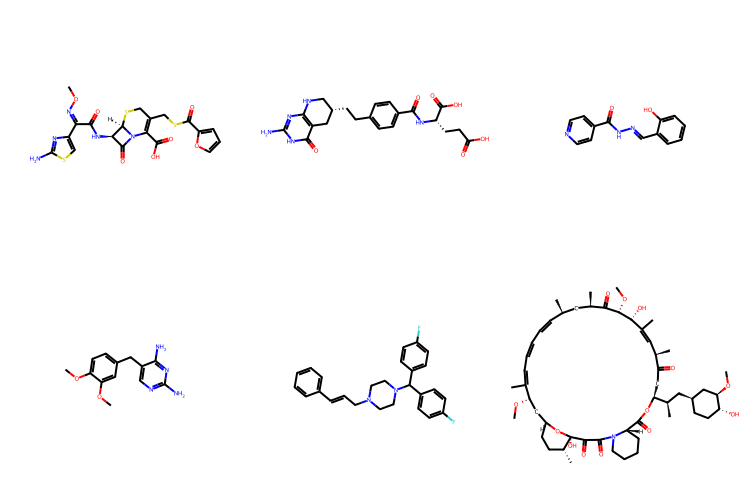

In [14]:
# Double check the lowest scoring compound manually (low scoring is better).

# The below are the top 5 binders from the cho_sim50 search - .csv output taken and 

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

a = Chem.MolFromSmiles('CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSC(=O)c3ccco3)CS[C@H]12)c1csc(N)n1')
b = Chem.MolFromSmiles('Nc1nc2c(c(=O)[nH]1)C[C@@H](CCc1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1)CN2')
c = Chem.MolFromSmiles('O=C(N/N=C/c1ccccc1O)c1ccncc1')
d = Chem.MolFromSmiles('COc1ccc(Cc2cnc(N)nc2N)cc1OC')
e = Chem.MolFromSmiles('Fc1ccc(C(c2ccc(F)cc2)N2CCN(C/C=C/c3ccccc3)CC2)cc1')
test = Chem.MolFromSmiles('CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H]([C@H](C)C[C@@H]2CC[C@@H](O)[C@H](OC)C2)CC(=O)[C@H](C)/C=C(\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)/C=C/C=C/C=C/1C')

Draw.MolsToGridImage((a,b,c,d,e, test), subImgSize=(250,250))


In [13]:
# finding correlations between the affinity and MW/rotatable bonds/heteroatms

csv_file = os.path.join(mypath, "affinities_smiles_descriptors.csv")

df = pd.read_csv(csv_file)



print(df['AFFINITY'].corr(df['MolWt']))
print(df['AFFINITY'].corr(df['NumHeteroatoms']))
print(df['AFFINITY'].corr(df['NumRotatableBonds']))

#remember - a lower affinity = predeicited tighter binding, so a negatice correlation means tighter binding.

-0.05419633066796997
0.005755647270683676
-0.020841124828861076
